# Eye State Classification from EEG Data

Electroencephalography, commonly known as EEG, is a technique used to capture the brain's electrical activity. It involves the use of wearable headgear fitted with nonintrusive electrodes that rest on the scalp.


eeg-eye-state
dataset from openml-ID-1471

```https://www.openml.org/data/download/1587924/phplE7q6h```

*Description*

Author: Oliver Roesler

Source: UCI, Baden-Wuerttemberg, Cooperative State University (DHBW), Stuttgart, Germany

Please cite: UCI

All data is from one continuous EEG measurement with the Emotiv EEG Neuroheadset. The duration of the measurement was 117 seconds. The eye state was detected via a camera during the EEG measurement and added later manually to the file after analyzing the video frames. '1' indicates the **eye-closed** and '0' the **eye-open** state. All values are in chronological order with the first measured value at the top of the data.

The features correspond to 14 EEG measurements from the headset, originally labeled AF3, F7, F3, FC5, T7, P, O1, O2, P8, T8, FC6, F4, F8, AF4, in that order.

Roesler,Oliver. (2013). EEG Eye State. UCI Machine Learning Repository. https://doi.org/10.24432/C57G7J.

- Sample Data

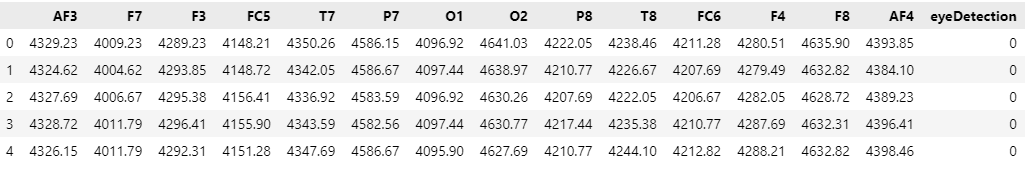

In [204]:
import openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from scipy.io.arff import loadarff  # To load arff files

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score, auc, make_scorer
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score, log_loss

#Linear algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Nonlinear algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#Ensemble methods - Boosting method
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
#Ensemble methods - Bagging method
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [205]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [206]:
# set ROOT_DIR as the data folder and read arff data from data folder
ROOT_DIR = Path('../data')
# read arff data from data folder
data, meta = loadarff(ROOT_DIR / 'EEG Eye State.arff')
data

array([(4329.23, 4009.23, 4289.23, 4148.21, 4350.26, 4586.15, 4096.92, 4641.03, 4222.05, 4238.46, 4211.28, 4280.51, 4635.9 , 4393.85, b'0'),
       (4324.62, 4004.62, 4293.85, 4148.72, 4342.05, 4586.67, 4097.44, 4638.97, 4210.77, 4226.67, 4207.69, 4279.49, 4632.82, 4384.1 , b'0'),
       (4327.69, 4006.67, 4295.38, 4156.41, 4336.92, 4583.59, 4096.92, 4630.26, 4207.69, 4222.05, 4206.67, 4282.05, 4628.72, 4389.23, b'0'),
       ...,
       (4277.44, 3990.77, 4246.67, 4113.85, 4333.33, 4615.38, 4072.82, 4623.59, 4193.33, 4212.82, 4160.51, 4257.95, 4591.79, 4339.49, b'1'),
       (4284.62, 3991.79, 4251.28, 4122.05, 4334.36, 4616.41, 4080.51, 4628.72, 4200.  , 4220.  , 4165.64, 4267.18, 4596.41, 4350.77, b'1'),
       (4287.69, 3997.44, 4260.  , 4121.03, 4333.33, 4616.41, 4088.72, 4638.46, 4212.31, 4226.67, 4167.69, 4274.36, 4597.95, 4350.77, b'1')],
      dtype=[('AF3', '<f8'), ('F7', '<f8'), ('F3', '<f8'), ('FC5', '<f8'), ('T7', '<f8'), ('P7', '<f8'), ('O1', '<f8'), ('O2', '<f8'), ('P8',

In [207]:
df = pd.DataFrame(data.tolist(), columns=meta.names())
df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.230,4009.230,4289.230,4148.210,4350.260,4586.150,4096.920,4641.030,4222.050,4238.460,4211.280,4280.510,4635.900,4393.850,b'0'
1,4324.620,4004.620,4293.850,4148.720,4342.050,4586.670,4097.440,4638.970,4210.770,4226.670,4207.690,4279.490,4632.820,4384.100,b'0'
2,4327.690,4006.670,4295.380,4156.410,4336.920,4583.590,4096.920,4630.260,4207.690,4222.050,4206.670,4282.050,4628.720,4389.230,b'0'
3,4328.720,4011.790,4296.410,4155.900,4343.590,4582.560,4097.440,4630.770,4217.440,4235.380,4210.770,4287.690,4632.310,4396.410,b'0'
4,4326.150,4011.790,4292.310,4151.280,4347.690,4586.670,4095.900,4627.690,4210.770,4244.100,4212.820,4288.210,4632.820,4398.460,b'0'


In [208]:
# Decode byte strings to regular strings in the 'eyeDetection' column
df['eyeDetection'] = df['eyeDetection'].str.decode('utf-8')
df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.230,4009.230,4289.230,4148.210,4350.260,4586.150,4096.920,4641.030,4222.050,4238.460,4211.280,4280.510,4635.900,4393.850,0
1,4324.620,4004.620,4293.850,4148.720,4342.050,4586.670,4097.440,4638.970,4210.770,4226.670,4207.690,4279.490,4632.820,4384.100,0
2,4327.690,4006.670,4295.380,4156.410,4336.920,4583.590,4096.920,4630.260,4207.690,4222.050,4206.670,4282.050,4628.720,4389.230,0
3,4328.720,4011.790,4296.410,4155.900,4343.590,4582.560,4097.440,4630.770,4217.440,4235.380,4210.770,4287.690,4632.310,4396.410,0
4,4326.150,4011.790,4292.310,4151.280,4347.690,4586.670,4095.900,4627.690,4210.770,4244.100,4212.820,4288.210,4632.820,4398.460,0


### EDA

In [209]:
# //create a function that does general EDA for the dataframe

def EDA(df, target = 'eyeDetection'):
    print("----------TOP 5 RECORDS----------")
    print(df.head())
    print("----------COLUMN NAMES----------")
    print(df.columns)
    print("----------DATA TYPES FOR EACH COLUMN----------")
    print(df.dtypes)
    print("----------MISSING VALUES----------")
    print(df.isnull().sum())
    print("----------NULL VALUES----------")
    print(df.isna().sum())
    print("----------SHAPE OF DATA----------")
    print(df.shape)
    print("----------DESCRIBE----------")
    print(df.describe())
    print("----------DUPLICATES----------")
    print(df.duplicated().sum())
    print("----------UNIQUE VALUES----------")
    print(df.nunique())
    print("----------TARGET VARIABLE LEVELS----------")
    print(df[target].unique())

EDA(df)


----------TOP 5 RECORDS----------
       AF3       F7       F3      FC5       T7       P7       O1       O2  \
0 4329.230 4009.230 4289.230 4148.210 4350.260 4586.150 4096.920 4641.030   
1 4324.620 4004.620 4293.850 4148.720 4342.050 4586.670 4097.440 4638.970   
2 4327.690 4006.670 4295.380 4156.410 4336.920 4583.590 4096.920 4630.260   
3 4328.720 4011.790 4296.410 4155.900 4343.590 4582.560 4097.440 4630.770   
4 4326.150 4011.790 4292.310 4151.280 4347.690 4586.670 4095.900 4627.690   

        P8       T8      FC6       F4       F8      AF4 eyeDetection  
0 4222.050 4238.460 4211.280 4280.510 4635.900 4393.850            0  
1 4210.770 4226.670 4207.690 4279.490 4632.820 4384.100            0  
2 4207.690 4222.050 4206.670 4282.050 4628.720 4389.230            0  
3 4217.440 4235.380 4210.770 4287.690 4632.310 4396.410            0  
4 4210.770 4244.100 4212.820 4288.210 4632.820 4398.460            0  
----------COLUMN NAMES----------
Index(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7',

In [210]:
df['eyeDetection'] = df['eyeDetection'].astype(int)

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int32  
dtypes: float64(14), int32(1)
memory usage: 1.7 MB


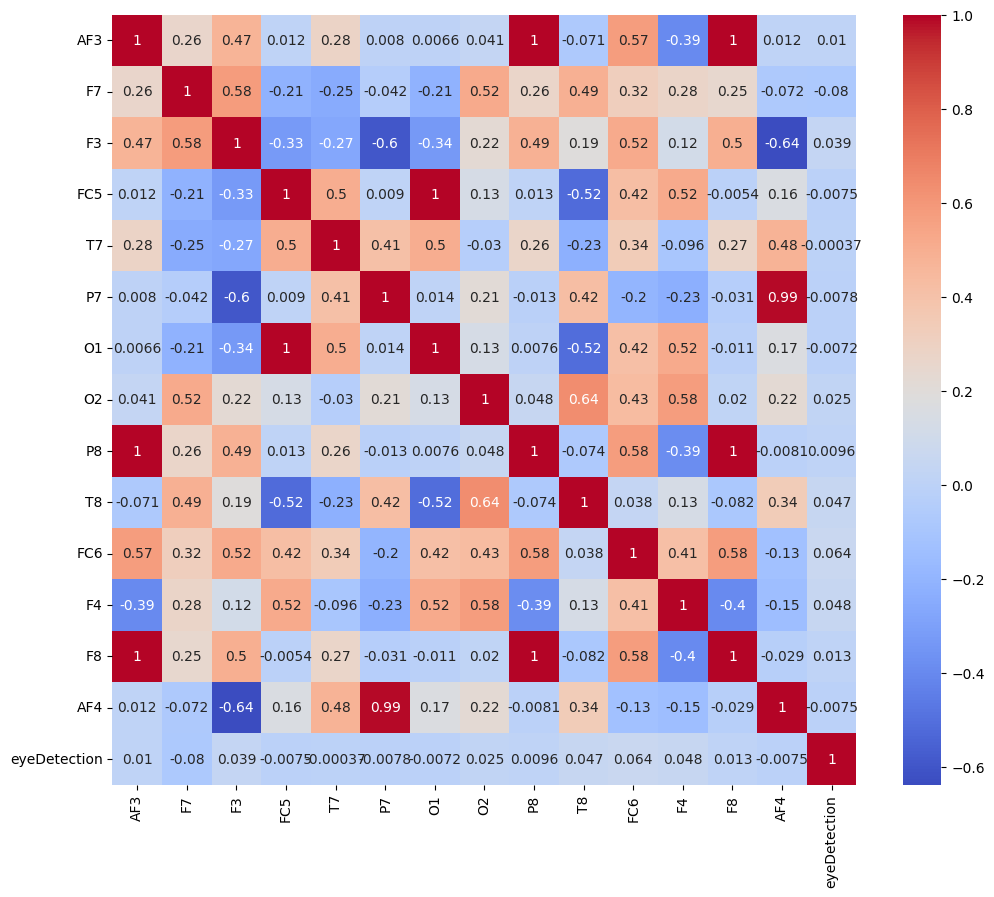

In [212]:
# plot correlation with target variable

corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


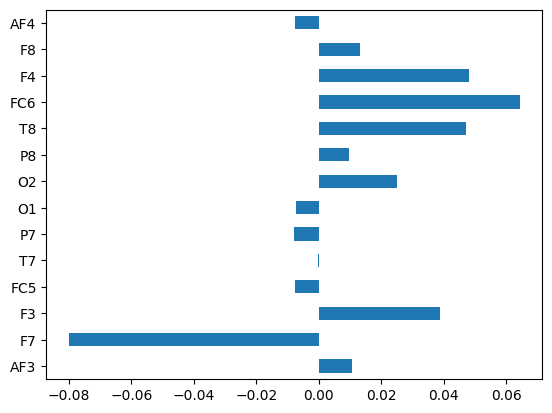

In [213]:
# correlation of all features except target feature with target feature
df.drop('eyeDetection', axis=1).apply(lambda x: x.corr(df.eyeDetection)).plot(kind='barh')
plt.show()

In [214]:
df.eyeDetection.value_counts()

eyeDetection
0    8257
1    6723
Name: count, dtype: int64

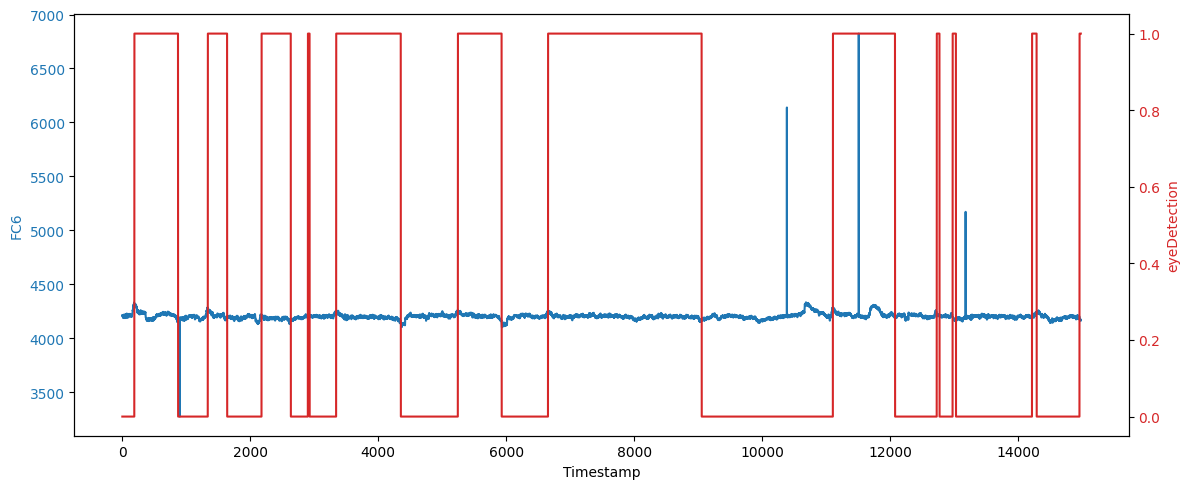

In [215]:
def plot_feature_with_target(df, feature, target):
    x = df.index
    y1 = df[feature]
    y2 = df[target]
    fig, ax1 = plt.subplots(figsize=(12,5))

    color = 'tab:blue'
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel(feature, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()

    color = 'tab:red'
    ax2.set_ylabel(target, color=color)
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()

plot_feature_with_target(df, 'FC6', 'eyeDetection')

### Data Cleaning

In [216]:
from scipy import stats

# //find outliers using z-score and fill with nan, then impute with linear interpolation for each feature and print how many records were updated

def remove_outliers(df, feature):
    z_scores = stats.zscore(df[feature])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3)
    # //count how many records were updated
    print(f'Number of outliers in {feature}: {len(df[~filtered_entries])}')
    df.loc[~filtered_entries, feature] = np.nan
    df[feature] = df[feature].interpolate(method='linear')
    return df


for feature in df.columns:
    if feature != 'eyeDetection':
        df = remove_outliers(df, feature)

df.head()


Number of outliers in AF3: 1
Number of outliers in F7: 17
Number of outliers in F3: 4
Number of outliers in FC5: 1
Number of outliers in T7: 37
Number of outliers in P7: 1
Number of outliers in O1: 1
Number of outliers in O2: 66
Number of outliers in P8: 1
Number of outliers in T8: 25
Number of outliers in FC6: 46
Number of outliers in F4: 4
Number of outliers in F8: 3
Number of outliers in AF4: 2


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.230,4009.230,4289.230,4148.210,4350.260,4586.150,4096.920,4641.030,4222.050,4238.460,4211.280,4280.510,4635.900,4393.850,0
1,4324.620,4004.620,4293.850,4148.720,4342.050,4586.670,4097.440,4638.970,4210.770,4226.670,4207.690,4279.490,4632.820,4384.100,0
2,4327.690,4006.670,4295.380,4156.410,4336.920,4583.590,4096.920,4630.260,4207.690,4222.050,4206.670,4282.050,4628.720,4389.230,0
3,4328.720,4011.790,4296.410,4155.900,4343.590,4582.560,4097.440,4630.770,4217.440,4235.380,4210.770,4287.690,4632.310,4396.410,0
4,4326.150,4011.790,4292.310,4151.280,4347.690,4586.670,4095.900,4627.690,4210.770,4244.100,4212.820,4288.210,4632.820,4398.460,0


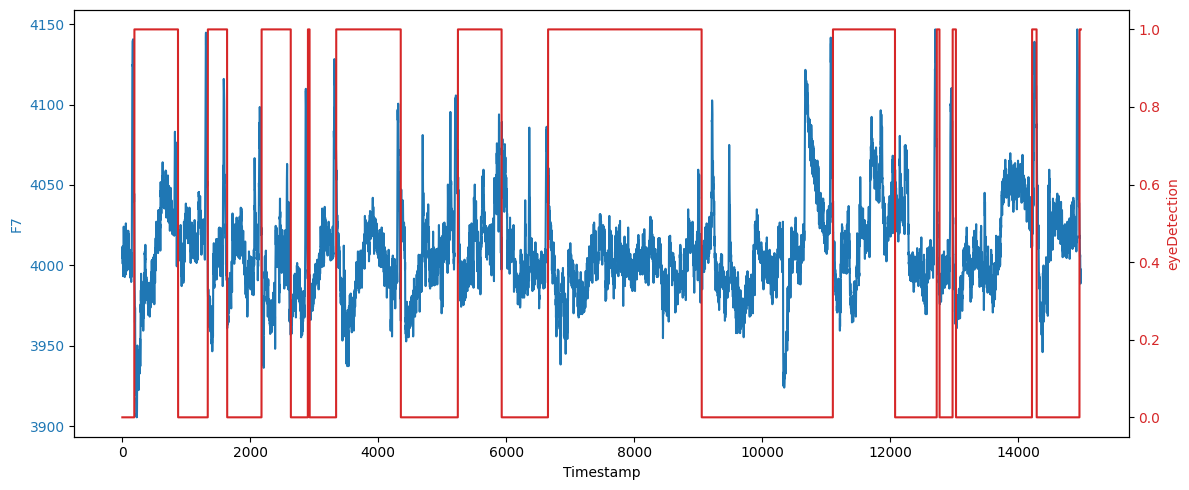

In [217]:
plot_feature_with_target(df, 'F7', 'eyeDetection')

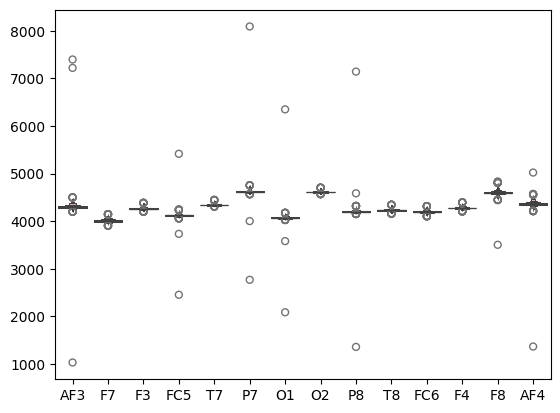

In [218]:
# //plot the distribution of each feature

sns.boxenplot(data=df.drop('eyeDetection', axis=1))
plt.show()


In [219]:
from sklearn.model_selection import TimeSeriesSplit

test_len = 0.2
test_size = int(len(df) * test_len)
train_size = len(df) - test_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(f'Train: {len(train)}')
print(f'Test: {len(test)}')

# create X and y
X = train.drop('eyeDetection', axis=1)
y = train['eyeDetection']

# create X test and y test
X_test = test.drop('eyeDetection', axis=1)
y_test = test['eyeDetection']

# perform time series split for validation
tscv = TimeSeriesSplit(n_splits=5, test_size=300)



Train: 11984
Test: 2996


Compare different models

In [230]:
scoring = {"accuracy": make_scorer(accuracy_score), 
            "balanced_accuracy": make_scorer(balanced_accuracy_score), 
            "f1": make_scorer(f1_score, pos_label=1), 
            "roc_auc": make_scorer(roc_auc_score, needs_threshold=True),
            "average_precision": make_scorer(average_precision_score, greater_is_better=True, needs_proba = True, pos_label=1), 
            "recall": make_scorer(recall_score, pos_label=1),
            "precision": make_scorer(precision_score, pos_label=1),
            # "matthews_corrcoef": make_scorer(matthews_corrcoef)
            }

In [231]:
index = []
scores = {
            "Accuracy": [], 
            "Balanced accuracy": [], 
            "F1 score": [], 
            "Precision": [], 
            "Recall": [], 
            "ROC AUC": [], 
            "PR AUC": [], 
            # "MCC": []
}

# //create dictionary of models with short names as keys
models = {"LR": LogisticRegression(max_iter=1000, n_jobs=-1, random_state=420),
          "LDA": LinearDiscriminantAnalysis(),
          "KNN": KNeighborsClassifier(),
          "CART": DecisionTreeClassifier(),
          "NB": GaussianNB(),
          "SVM": SVC(),
          "XGB": XGBClassifier(n_jobs=-1, random_state=420),
          "AB": AdaBoostClassifier(),
          "GBM": GradientBoostingClassifier(),
          "RF": RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=420),
          "ET": ExtraTreesClassifier(),
          "LGBM": LGBMClassifier(n_jobs=-1, random_state=420)
          }



In [232]:
# //add the cv score for each model to the scores dictionary and finally create a dataframe of the scores dictionary
final_score = pd.DataFrame()

def report_scores(cv_result, index, scores):
    scores["Accuracy"].append(cv_result["test_accuracy"].mean())
    scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())
    scores["F1 score"].append(cv_result["test_f1"].mean())
    scores["Precision"].append(cv_result["test_precision"].mean())
    scores["Recall"].append(cv_result["test_recall"].mean())
    scores["ROC AUC"].append(cv_result["test_roc_auc"].mean())
    scores["PR AUC"].append(cv_result["test_average_precision"].mean())
    # scores["MCC"].append(cv_result["test_matthews_corrcoef"].mean()) 
    df_scores = pd.DataFrame(scores, index=index)
    # df_scores = pd.DataFrame(scores)
    print(df_scores)
    return df_scores

results = []
names = []

for name, model in models.items():
    # cv_results = cross_val_score(model, X, y, cv=tscv, scoring='accuracy', n_jobs=-1)
    cv_results = cross_validate(model, X, y, cv=tscv, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    # msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    # print(msg)

# //create a dataframe from the mean of results list and names list 

df_results = pd.DataFrame(columns=['model', 'accuracy', 'balanced_accuracy', 'f1', 'roc_auc', 'average_precision', 'precision', 'recall'])
for i in range(len(results)):
    df_results.loc[i] = [names[i], 
                         results[i]['test_accuracy'].mean(), 
                         results[i]['test_balanced_accuracy'].mean(), 
                         results[i]['test_f1'].mean(), 
                         results[i]['test_roc_auc'].mean(), 
                         results[i]['test_average_precision'].mean(), 
                         results[i]['test_precision'].mean(), 
                         results[i]['test_recall'].mean()]

df_results


,model,accuracy,balanced_accuracy,f1,roc_auc,average_precision,precision,recall
0,LR,0.635,0.572,0.467,NaN,0.564,0.581,0.414
1,LDA,0.371,0.346,0.304,NaN,0.563,0.558,0.211
2,KNN,0.449,0.476,0.281,NaN,0.596,0.396,0.218
3,CART,0.432,0.399,0.297,NaN,0.591,0.391,0.254
4,NB,0.552,0.589,0.345,NaN,0.600,0.400,0.313
5,SVM,0.281,0.296,0.289,NaN,NaN,0.590,0.205
6,XGB,0.482,0.457,0.330,NaN,0.597,0.593,0.288
7,AB,0.395,0.401,0.237,NaN,0.597,0.394,0.181
8,GBM,0.423,0.407,0.264,NaN,0.595,0.592,0.211
9,RF,0.399,0.392,0.280,NaN,0.597,0.595,0.231


In [233]:
# create a model
model = XGBClassifier()

# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=tscv, n_jobs=-1)
print(f'Accuracy: {np.mean(scores)}')
print(f'Standard Deviation: {np.std(scores)}')
print(f'Accuracy per fold: {scores}')


Accuracy: 0.3295685212655147
Standard Deviation: 0.40464061726293016
Accuracy per fold: [0.         0.         0.90702087 0.73417722 0.00664452]


In [235]:
# create a model
model = XGBClassifier(max_depth=8, random_state=42, n_jobs=-1)

# fit model
model.fit(X, y, verbose=False)


# make predictions
predictions = model.predict(X_test)

# evaluate predictions
print(f'Accuracy: {accuracy_score(y_test, predictions)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, predictions)}')
print(f'Classification Report: \n{classification_report(y_test, predictions)}')



Accuracy: 0.4909879839786382
Confusion Matrix: 
[[1279 1437]
 [  88  192]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.47      0.63      2716
           1       0.12      0.69      0.20       280

    accuracy                           0.49      2996
   macro avg       0.53      0.58      0.41      2996
weighted avg       0.86      0.49      0.59      2996



In [236]:
lr = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=420)
lr.fit(X, y)

# make predictions
predictions = lr.predict(X_test)

# evaluate predictions
print(f'Accuracy: {accuracy_score(y_test, predictions)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, predictions)}')
print(f'Classification Report: \n{classification_report(y_test, predictions)}')



Accuracy: 0.27069425901201605
Confusion Matrix: 
[[ 549 2167]
 [  18  262]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.20      0.33      2716
           1       0.11      0.94      0.19       280

    accuracy                           0.27      2996
   macro avg       0.54      0.57      0.26      2996
weighted avg       0.89      0.27      0.32      2996



In [244]:
import pickle

MODEL_DIR = Path('../models')
MODEL_DIR.mkdir(exist_ok=True)

# save the model to disk
filename = 'xgb_model.bin'
pickle.dump(model, open(MODEL_DIR / filename, 'wb'))


In [250]:
# //create a test sample using JSON

import json
import numpy as np

# create a test sample
test_sample = X_test.iloc[0:1]
test_sample = test_sample.to_json(orient='records')
test_sample = json.loads(test_sample)[0]
test_sample = np.array(list(test_sample.values())).reshape(1, -1)
test_sample


array([[4311.79, 4029.74, 4289.23, 4169.74, 4381.54, 4650.26, 4096.41,
        4631.79, 4216.92, 4236.41, 4194.36, 4287.18, 4617.44, 4369.74]])

In [251]:
model.predict_proba(test_sample)[0, 1]

0.96623933